In [99]:
from IPython.display import display, Latex
from pathlib import Path
import json
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import keras_tuner as kt
# import tensorflow as tf

import hyper_model_creator

In [66]:
figures_dir = Path('report', 'figures', 'figures_tuner')

In [62]:
trials_dir = Path('trials', 'hyperband_resnet')
hypermodel = hyper_model_creator.BuildHyperModel()

tuner = kt.Hyperband(
    hypermodel,
    objective=kt.Objective('val_weightedf2score', direction='max'),
    directory=trials_dir.parent,
    project_name=trials_dir.name,
)
hp = tuner.oracle.get_space()

Reloading Tuner from trials/hyperband_resnet/tuner0.json


In [107]:
rows = []
for p in hp.space:
    config = p.get_config()
    rows.append(config)

search_space = pd.DataFrame(rows)[['name', 'values']].fillna('[true, false]').astype('string')
for c in space.columns: 
    search_space[c] = search_space[c].str.replace('_', '\\_')

search_space.to_latex(
    figures_dir.joinpath('fixed_layers.tex'),
    index=False,
    caption='Summary of initial hyperparameter search space.',
    label='tab:fixed_layers'
)
search_space

,name,values
0,class\_weight,"[true, false]"
1,training\_years,"['2017\_2018\_2019', '2017']"
2,kernel\_regularizer,"['l1l2', 'l1', 'l2']"
3,spatial\_dropout,"[0.3, 0.1, 0.5]"
4,activation,"['leaky\_relu', 'relu']"
5,pool\_size,"[4, 2]"
6,dropout,"[0.3, 0.1, 0.5]"
7,bias\_initializer,"[true, false]"
8,learning\_rate,"[0.001, 0.0001, 0.01]"
9,loss\_function,"['binary\_focal\_crossentropy', 'binary\_cross..."


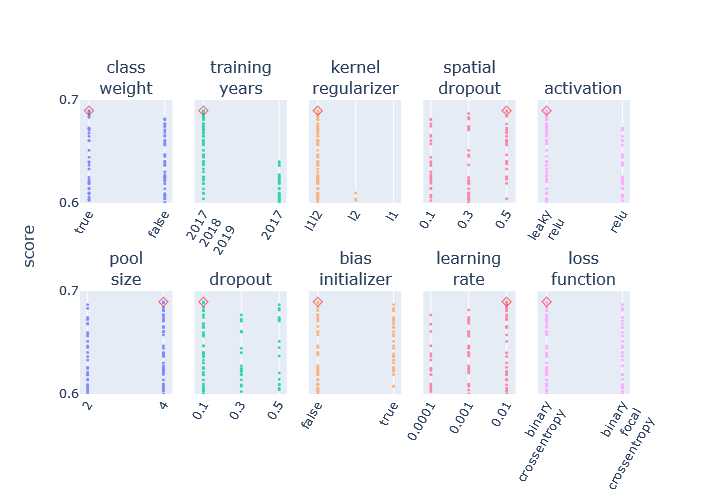

In [45]:
rows = []
for trial in sorted(list(trials_dir.glob('trial_*'))):
    with open(trial.joinpath('trial.json')) as f:
        results = json.load(f)
        row = {'score': results['score']} | results['hyperparameters']['values']
        rows.append(row)

trials_df = pd.DataFrame(rows).sort_values(by='score', ascending=False)
trials_df = trials_df[[c for c in trials_df.columns if 'tuner' not in c]]

nrows, ncols = 2, 5
fig = make_subplots(
    rows=nrows, cols=ncols, shared_yaxes='all', y_title='score',
    subplot_titles=trials_df.columns[1:].str.replace('_', '<br>'),
    vertical_spacing=0.3,
)

for i, col in enumerate(trials_df.columns[1:]):
    if trials_df[col].dtype == object:
        x = trials_df[col].str.replace('_', '<br>')
    else:
        x = trials_df[col]

    position = dict(row=(i//ncols)+1, col=(i%ncols)+1)
    fig.append_trace(go.Scatter(
        y=trials_df['score'],
        x=x,
        mode='markers',
        marker_size=3,
        opacity=0.8,
    ), **position)
    
    fig.append_trace(go.Scatter(
        y=[trials_df['score'].max()],
        x=[x[trials_df['score'].idxmax()]],
        mode='markers',
        marker_symbol='diamond-open',
        marker_color='red',
        marker_size=7,
        opacity=0.6,
    ), **position)

    fig.update_xaxes(
        type='log' if 'learning_rate' in col else None,
        tickformat='.1r',
        tickangle=-60,
        tickvals=x.unique(),
        **position
    )
    fig.update_yaxes(range=[0.6, 0.7], tickvals=[0.6, 0.7])

fig.update_layout(
    height=500, width=700, showlegend=False,
    margin=dict(l=80, r=80, t=100, b=80)
)
fig.write_image(figures_dir.joinpath('fixed_layers.pdf'))
fig.show()

In [122]:
hp.space[1]

Choice(name: 'training_years', values: ['2017_2018_2019', '2017'], ordered: False, default: 2017_2018_2019)